# Preparing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/'

%cd "{root_dir}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
!pip install pandas==0.24.0
!pip install partd

In [ ]:
import pandas as pd
from pathlib import Path
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

import dask.dataframe as dd

from scipy.sparse import csr_matrix as sparce_matrix

tqdm.pandas()

tmp_dir = Path('/')

In [ ]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [ ]:
def reduce_mem_usage(df, ignore_cols=[]):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        print(col, col_type)

        if col in ignore_cols:
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
        print("\tNew dtype:  ", df[col].dtype)
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

# Merge diffent types of action data into single file

In [ ]:
preprocessed_dir = Path(f'Datasets/CERT_output/')
assert(preprocessed_dir.is_dir())

In [ ]:
logon_df = pd.read_csv(preprocessed_dir/ 'logon_preprocessed.csv',
                      usecols = ['id', 'date', 'user', 'is_usual_pc', 'is_work_time', 'subtype'])
logon_df['type'] = 'logon'
print('logon')

http_df = pd.read_csv(preprocessed_dir/ 'http_preprocessed.csv',
                      usecols = ['id','date', 'user', 'is_usual_pc', 'is_work_time', 'subtype'])
http_df['type'] = 'http'
http_df = http_df.drop(http_df[http_df.is_usual_pc == 'is_usual_pc'].index)
# http_df = http_df.replace({'is_work_time': {'True': True, 'False': False},
#                            'is_usual_pc': {'True': True, 'False': False}})
http_df.subtype = http_df.subtype.map(int)
print('http')

device_df = pd.read_csv(preprocessed_dir/ 'device_preprocessed.csv',
                      usecols = ['id','date', 'user', 'is_usual_pc', 'is_work_time', 'subtype'])
device_df['type'] = 'device'
print('device')

email_df = pd.read_csv(preprocessed_dir/ 'email_preprocessed.csv',
                      usecols = ['id','date', 'user', 'is_usual_pc', 'is_work_time', 'subtype'])
email_df['type'] = 'email'
email_df.subtype = email_df.subtype.map({True: 'external', False: 'internal'})
print('email')

file_df = pd.read_csv(preprocessed_dir/ 'file_preprocessed.csv',
                      usecols = ['id','date', 'user', 'is_usual_pc', 'is_work_time', 'subtype'])
file_df['type'] = 'file'
print('file')

logon


/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


http
device
email
file


In [ ]:
df = pd.concat([logon_df, http_df, device_df, email_df, file_df], axis=0)
df.isna().sum()

id              0
date            0
user            0
is_usual_pc     0
is_work_time    0
subtype         0
type            0
dtype: int64

In [ ]:
del logon_df
del http_df
del file_df
del device_df
del email_df

In [ ]:
df = reduce_mem_usage(df, ignore_cols=['id', 'date'])

Memory usage of dataframe is 1562.61MB
id object
date object
user object
	New dtype:   category
is_usual_pc bool
	New dtype:   float16
is_work_time bool
	New dtype:   float16
subtype object
	New dtype:   category
type object
	New dtype:   category
Memory usage after optimization is: 1000.12MB
Decreased by 36.0%


In [ ]:
subtype_encoder = LabelEncoder()

df.subtype = df.subtype.map(str)
df['subtype'] = subtype_encoder.fit_transform(df['subtype'])

type_encoder = LabelEncoder()

df['type'] = type_encoder.fit_transform(df['type'])

df.is_work_time = df.is_work_time.astype(np.int8)
df.is_usual_pc = df.is_usual_pc.astype(np.int8)

df['action_id'] = df.is_usual_pc * 32 + df.is_work_time * 16 + df.subtype
df = df[['id', 'date', 'user', 'action_id']]
df['date'] = pd.to_datetime(df.date, format='%Y/%m/%d %H:%M:%S')

df.to_pickle(str(tmp_dir / "df.pkl"))
del df

# Merge diffent types of content topics data into single file

In [ ]:
content_dir = Path(f'Datasets/CERT_output/')
assert(content_dir.is_dir())

email_content_df = pd.read_csv(content_dir/ 'email_lda_content.csv',
                      usecols = ['id', 'content'])
email_content_df['type'] = 'email'
print('email')

file_content_df = pd.read_csv(content_dir/ 'file_lda_content.csv',
                      usecols = ['id', 'content'])
file_content_df['type'] = 'file'
print('file')

http_content_df = pd.read_csv(content_dir/ 'http_lda_content.csv',
                      usecols = ['id', 'content'])
http_content_df['type'] = 'http'
print('http')

email
file
http


In [ ]:
email_content_df = reduce_mem_usage(email_content_df, ignore_cols=['id', 'content'])
file_content_df = reduce_mem_usage(file_content_df, ignore_cols=['id', 'content'])
http_content_df = reduce_mem_usage(http_content_df, ignore_cols=['id', 'content'])

Memory usage of dataframe is 60.20MB
id object
content object
type object
	New dtype:   category
Memory usage after optimization is: 42.64MB
Decreased by 29.2%
Memory usage of dataframe is 10.20MB
id object
content object
type object
	New dtype:   category
Memory usage after optimization is: 7.22MB
Decreased by 29.2%
Memory usage of dataframe is 650.88MB
id object
content object
type object
	New dtype:   category
Memory usage after optimization is: 461.04MB
Decreased by 29.2%


In [ ]:
df_content = pd.concat([email_content_df, file_content_df, http_content_df], axis=0)

In [ ]:
del email_content_df
del file_content_df
del http_content_df

In [ ]:
df_content = reduce_mem_usage(df_content, ignore_cols=['id', 'content'])

Memory usage of dataframe is 961.70MB
id object
content object
type object
	New dtype:   category
Memory usage after optimization is: 751.33MB
Decreased by 21.9%


In [ ]:
df_content.to_csv(str(tmp_dir / 'df_content.csv'))

# Merge content topics and action datasets

In [ ]:
df_content = dd.read_csv(str(tmp_dir / 'df_content.csv'))\
    .set_index('id').drop('Unnamed: 0', axis=1)
df = pd.read_pickle(str(tmp_dir / "df.pkl"))
# df = dd.read_csv('/df.csv').set_index('id').drop('Unnamed: 0', axis=1)

# Merge the csv files.
df = dd.merge(df_content, df, how='inner', on=['id'])

[########################################] | 100% Completed |  1min 46.5s


In [ ]:
# Write the output.
# df.to_csv('/result2.csv', index=False, single_file=True)
df.to_parquet(str(tmp_dir / 'df_merged.parquet'))

[########################################] | 100% Completed | 35min  9.8s


# Dask for aggregating content data

In [ ]:
# df['date'] = dd.to_datetime(df.date, format='%Y/%m/%d %H:%M:%S')

In [ ]:
df = df.reset_index().drop(['index', 'type'], axis=1)
df['day'] = df.date.dt.floor('D')
df.set_index('date')

action_id_lists = df.groupby(['user', 'day'], sort=True)\
    ['action_id'].apply(list)

content_lists = df.groupby(['user', 'day'], sort=True)\
    ['content'].apply(list)

action_id_lists = action_id_lists.reset_index().dropna()
content_lists = content_lists.reset_index().dropna()

df_merged = dd.merge(action_id_lists, content_lists, how='inner', on=['user', 'day'])

df_merged.to_csv(str(tmp_dir / "aggregated_merged_df.csv"), index=False, single_file=True)
df = df_merged

[########################################] | 100% Completed | 35min 58.0s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  import sys


[########################################] | 100% Completed | 42min 44.6s


# Add labels

In [ ]:
answers_csv = Path(root_dir) / "Datasets/CERT/answers/insiders.csv"
dataset_version = '4.2'
assert(answers_csv.is_file())

main_df = pd.read_csv(answers_csv)
main_df = main_df[main_df['dataset'].astype(str) == str(dataset_version)]\
    .drop(['dataset', 'details'], axis=1)

main_df['start'] = pd.to_datetime(main_df['start'], format='%m/%d/%Y %H:%M:%S')
main_df['end'] = pd.to_datetime(main_df['end'], format='%m/%d/%Y %H:%M:%S')

In [ ]:
df = pd.read_csv(str(tmp_dir / "aggregated_merged_df.csv"))
df['day'] = pd.to_datetime(df['day'])

In [ ]:
df = df.merge(main_df, left_on='user', right_on='user', how='left')

df['malicious'] = (df.day >= df.start) & (df.day <= df.end)
df = df.drop(['start', 'end', 'day', 'user'], axis=1)

df.loc[df['malicious'] == False, 'scenario'] = 0

# df.to_csv(preprocessed_dir / 'aggregated_merged_df.csv', index=False)
df.to_csv(str(tmp_dir / 'aggregated_merged_answers_df.csv'), index=False)

In [ ]:
%cp "/aggregated_merged_answers_df.csv" "aggregated_merged_answers_df.csv"

# Content topics parsing

In [ ]:
Path('aggregated_merged_answers_df.csv').is_file()

True

In [ ]:
import pandas as pd
import ast
df = pd.read_csv(str(tmp_dir / 'aggregated_merged_answers_df.csv'),)
df = reduce_mem_usage(df, ignore_cols=['action_id', 'content'])

Memory usage of dataframe is 7.86MB
action_id object
content object
scenario float64
	New dtype:   float16
malicious bool
	New dtype:   float16
Memory usage after optimization is: 6.29MB
Decreased by 20.0%


In [ ]:
def parse_action_row(row):
    row = ast.literal_eval(row)
    action_list = []
    for action_num, action in enumerate(row):
        action = ast.literal_eval(action)
        action_list.append(action)
    return action_list

# for idx, row in tqdm(enumerate(content_array)):
#     content_array[idx] = parse_action_row(row)

In [ ]:
from scipy.sparse import csc_matrix

pbar = tqdm(total=df.shape[0])
for idx, row in df.iterrows():
    
    row.content = ast.literal_eval(row.content)

    # content = np.zeros((len(row), 100))
    content = csc_matrix((len(row.content), 100))

    for action_num, action in enumerate(row.content):
        action = ast.literal_eval(action)
        for topic, prob in action:
            content[action_num, topic] = prob

    row.action_id = ast.literal_eval(row.action_id)

    df.at[idx,'action_id'] = row.action_id
    df.at[idx,'content'] = content
    if idx % 100 == 0:
        pbar.update(100)

# with open('content_array.pkl', 'wb') as handle:
#     pickle.dump(content_array, handle)
df.to_pickle('df_final.pkl')

  0%|          | 0/329845 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
329900it [5:32:35, 16.76it/s]

In [ ]:
len(df['action_id'][444])

177

In [ ]:
df.content[444].shape[0]

177

In [ ]:
import pickle
with open('content_array.pkl', 'rb') as handle:
    content_array = pickle.load(handle)

In [ ]:
 from scipy.sparse import csc_matrix

a = csc_matrix(a)
csc_matrix((a.data, a.indices, a.indptr), shape=(200, 100))

In [ ]:
for idx, topic_matrix in tqdm(enumerate(content_array)):

    a = csc_matrix(topic_matrix)
    # a = csc_matrix((a.data, a.indices, a.indptr), shape=(200, 100))
    content_array[idx] = a

329845it [00:40, 8172.17it/s]


# Aggregate data (old pandas version)

In [ ]:
df['day'] = df.date.dt.floor('D')

In [ ]:
df = df.sort_values(['user', 'date'])

In [ ]:
df = df.reset_index().drop(['index', 'date'], axis=1)

In [ ]:
result = df.groupby(['user', 'day'], sort=False, as_index=True).agg(list)

In [ ]:
aggregated = result

In [ ]:
aggregated.to_pickle("aggregated.pkl")

In [ ]:
aggregated = aggregated.reset_index().dropna().drop(['user', 'day'], axis=1)

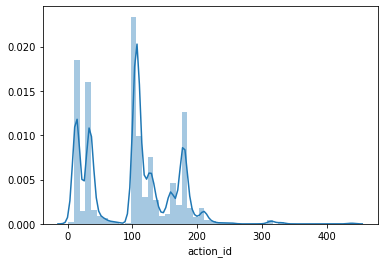

In [ ]:
 sns.distplot(aggregated.action_id.map(len))

In [ ]:
aggregated.head()

,action_id
2,"[61, 57, 54, 54, 54, 62, 62, 62, 54, 62, 62, 6..."
3,"[61, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 5..."
4,"[61, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 5..."
5,"[61, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 5..."
6,"[61, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 6..."


In [ ]:
aggregated.values

array([[list([61, 57, 54, 54, 54, 62, 62, 62, 54, 62, 62, 63, 54, 54, 62, 62, 63, 63, 54, 54, 62, 63, 63, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 63, 55, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 57, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 44])],
       [list([61, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 57, 54, 54, 54, 54, 54, 54, 54, 54, 63, 54, 63, 62, 54, 54, 54, 54, 54, 54, 54, 62, 54, 63, 54, 62, 54, 54, 54, 54, 63, 54, 63, 63, 63, 62, 63, 63, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 54, 54, 5